## An Exploration of Dirichlet Process Gaussian Mixture Model

I will explore the application of dirichlet process, specifically, Chinese Restaurant Process (CRP), on clustering when given data, which is generated from a one-dimensional gaussian mixture model.


In [0]:
# Some library we will use
import numpy as np
import warnings
from scipy.special import softmax
import matplotlib.pyplot as plt

# fix random seed
np.random.seed(0)

Before we start, we first define some helper functions, such as the probability density function of normal distribution:

In [0]:
def normalPDF(x, mu, scale):
    y = (x - mu) / scale
    return np.exp(- y ** 2 / 2) / np.sqrt(2 * np.pi) / scale

sampling function for sampling from normal-gamma distribution:

In [0]:
def normalGamma(mu, l, alpha, beta):
    tau = np.mean(np.random.gamma(alpha, 1/beta, 100))
    m = np.mean(np.random.normal(mu, 1 / (l * tau), 100 ))
    return m, tau

We use normal-gamma distribution to sample tau instead of sigma for code simplicity 

### Data

Let's first write a class that could generate data from gaussian mixture model. The parameters could be randomly chosen or fixed in advance.

In [0]:
class GaussianMixtureOneDim(object):
    """ One dimension Gaussian Mixture Data Generator
    """
    def __init__(self, num_comp, fix_param = {'pi': None, 'mu': None, 'sigma': 1}, params=None):
        super(GaussianMixtureOneDim, self).__init__()
        self.num_comp = num_comp
        assert self.num_comp > 0, 'Invalid number of components.'
        # self.size = size
        self.dim = 1 
        if params:
            self.pi = params['pi']
            self.mu = params['mu']
            self.sigma = params['sigma']
            assert len(self.pi) == self.num_comp, 'Parameter pi number mismatch.'
            assert len(self.mu) == self.num_comp, 'Parameter pi number mismatch.'
            assert len(self.sigma) == self.num_comp, 'Parameter pi number mismatch.'
        else:
            self.pi, self.mu, self.sigma = self._randomGenerate(fix_param = fix_param)

    def __str__(self):
        weights = []
        output_str = []
        for idx in range(self.num_comp):
            weights.append(-self.pi[idx])
            output_str.append('{:.2f} * N({:.2f}, {:.2f})'.format(self.pi[idx], self.mu[idx], self.sigma[idx]))

        out = [x for _, x in sorted(zip(weights, output_str))]
        return ' + '.join(out) 

    def _randomGenerate(self, fix_param):
        """ Random generate parameters, could fix to specific values
        """
        np.random.seed(1024)
        if not fix_param['pi']:
            pi = softmax(np.random.random(size=[self.num_comp, ]))
        else:
            if type(fix_param['mu']) != list:
                if not np.isclose(fix_param['mu'] * self.num_comp, 1):
                    warnings.warn('Sum of pi is not one, change to {:.2f}'.format(1.0/self.num_comp))
                mu = np.array([1.0/self.num_comp for _ in range(self.num_comp)]).reshape(self.num_comp, )
            else:
                assert len(fix_param['mu']) == self.num_comp, 'Fixed number of mu mismatch'
                assert np.isclose(np.sum(fix_param['pi']), 1), 'Sum of mixing propotions is not 1'
                pi = np.array(fix_param['pi']).reshape(self.num_comp, )
        
        if not fix_param['mu']:
            mu = np.random.random(size=[self.num_comp, ]) * self.num_comp
        else:
            if type(fix_param['mu']) != list:
                mu = np.array([fix_param['mu'] for _ in range(self.num_comp)]).reshape(self.num_comp, )
            else:
                assert len(fix_param['mu']) == self.num_comp, 'Fixed number of mu mismatch'
                mu = np.array(fix_param['mu']).reshape(self.num_comp, )
        if not fix_param['sigma']:
            sigma = np.random.random(size=[self.num_comp, ])
        else:
            if type(fix_param['sigma']) != list:
                sigma = np.array([fix_param['sigma'] for _ in range(self.num_comp)]).reshape(self.num_comp, )
            else:
                assert len(fix_param['sigma']) == self.num_comp, 'Fixed number of sigma mismatch'
                sigma = np.array(fix_param['sigma']).reshape(self.num_comp, )
        
        return pi, mu, sigma
    
    def pdf(self, X):
        Y = [0.]*len(X)
        for idx in range(self.num_comp):
            Y += self.pi[idx] * normalPDF(X, mu=self.mu[idx], scale=self.sigma[idx])
        return Y

    def plot(self):
        r = max(self.mu) + max(self.sigma) * 3 
        X = np.arange(-r, r, 0.1)
        Y = self.pdf(X)
        plt.plot(X, Y)
        plt.show()

    def _generateSingleComponent(self, idx, N):
        return self.pi[idx] * np.random.normal(loc=self.mu[idx], scale=self.sigma[idx], size=[N, self.dim])
    
    def generateData(self, N, show=False):
        data = np.zeros(shape=[N, self.dim])
        k_choices = np.random.choice(a=self.num_comp, size=N, p=self.pi)

        for idx in range(N):
            data[idx] = np.random.normal(loc=self.mu[k_choices[idx]], scale=self.sigma[k_choices[idx]])
        # for idx in range(self.num_comp):
            # data += self._generateSingleComponent(idx, N)
        
        if show:
            print("---Showing some datapoints---")
            for i in range(min(5, N)):
                print('Datapoint {}:\t'.format(i), data[i])
            print("------------End--------------")

        return data

    def dumpData(self, data, path='./'):
        np.save(path+'gmm-{}.npy'.format(data.shape[0]), data)

For simplicity, in this homework, I will fix the parameters to have the following Gaussian Mixture:
$$
0.3\mathcal{N}(-3, 1) + 0.4\mathcal{N}(0, 1) + 0.3\mathcal{N}(3, 1)
$$
From now on, I will refer this distribution as *True distribution* since it is where our data is sampled. To make sure we have sufficient data, we generate ten thousand data points. 

In [0]:
gmm = GaussianMixtureOneDim(num_comp = 3, fix_param={'pi': [0.3, 0.4, 0.3], 'mu': [-3 , 0, 3], 'sigma': 1})
data = gmm.generateData(N = 10000, show=True)

---Showing some datapoints---
Datapoint 0:	 [0.75316665]
Datapoint 1:	 [5.58322062]
Datapoint 2:	 [-0.49462158]
Datapoint 3:	 [0.82718506]
Datapoint 4:	 [0.21530848]
------------End--------------


The code above shows the first 5 data points in the dataset. Now let's look at histogram (with 20 bins) of these 10k data points

(array([  15.,   42.,  148.,  408.,  663.,  760.,  671.,  572.,  752.,
        1026.,  971.,  718.,  591.,  686.,  765.,  657.,  376.,  148.,
          29.,    2.]),
 array([-6.39667038, -5.75041209, -5.10415379, -4.4578955 , -3.81163721,
        -3.16537891, -2.51912062, -1.87286232, -1.22660403, -0.58034573,
         0.06591256,  0.71217086,  1.35842915,  2.00468745,  2.65094574,
         3.29720404,  3.94346233,  4.58972063,  5.23597892,  5.88223722,
         6.52849551]),
 <a list of 20 Patch objects>)

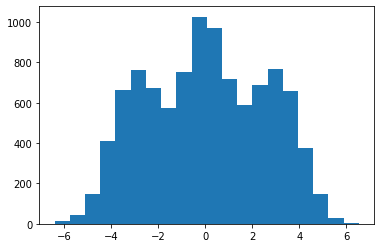

In [0]:
plt.hist(data.reshape(-1,), bins=20)

As a comparison, let's have a look at the probability density function of true distribution.

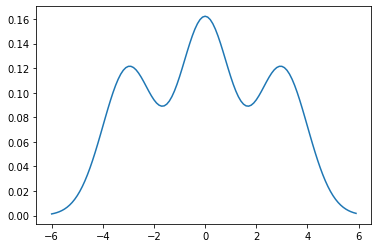

In [0]:
gmm.plot()

As we can see, the histogram is pretty close to the probability density function, which suggests that our data is reliable and representative enough for a model to learn from.

### Gaussian Component


We will use Gaussian distribution as the base distribution. In the Dirichlet process, each component will be a Gaussian distribution. Since we generate data from a Gaussian Mixture, a Gaussian component is reasonable. We do not discuss the choice of base distribution here.

In [0]:
class GaussianComponent(object):
    """
    """
    def __init__(self, params, fix_tau=True):
        super().__init__()
        self.mu0 = params['mu0']
        self.lambda0 = params['sigma0']
        self.a0 = params['a0']
        self.b0 = params['b0']
        
        self.sigma = 1
        self.num = 0

        # sum of the data
        self.sum = 0.
        # sum of the squared data
        self.sum2 = 0.

        self.fix_tau = fix_tau

    # print current Gaussian component
    def __str__(self):
        self.posterior() # update parameter
        mu_mean = float(self.mu)
        if self.fix_tau:
            sigma2_mean = 1
        else:
            sigma2_mean = float((self.b / self.a)**2)
        return 'N({:.2f}, {:.2f})'.format(mu_mean, sigma2_mean)
    
    # add a new data point into this component
    def add(self, x):
        self.num += 1
        self.sum += x
        self.sum2 += x ** 2
    
    # delete a data point from this component
    def delete(self, x):
        self.num -= 1
        self.sum -= x
        self.sum2 -= x ** 2
    
    # calculate the posterior parameters of mu and tau
    def posterior(self):
        if self.num == 0:
            self.mu = self.mu0
            self.l = self.lambda0
            self.a = self.a0
            self.b = self.b0         
        else:
            self.mu = (self.mu0 * self.lambda0 + self.sum) / (self.lambda0 + self.num) 
            self.l = self.lambda0 + self.num
            self.a = self.a0 + self.num / 2.0
            self.b = self.b0 + 0.5 * (self.sum2 - self.sum**2/self.num + (self.lambda0 * self.num * (self.sum/self.num - self.mu0) ** 2 ) / (self.lambda0 + self.num))

        return normalGamma(mu=self.mu, l=self.l, alpha=self.a, beta=self.b)
    
    # calculate the probability density function given data X
    def pdf(self, X):
        m, tau = self.posterior()
        if self.fix_tau:
            tau = 1

        return normalPDF(X, m, 1/tau)

We define the Gaussian component only with its sufficient statistics, i.e. the sum of the data, the sum of the squared data, and the number of datapoints belongs to this component. When we add/detele a data point into/from this component, we modify these three statistics to calculate the posterior parameters as well as the probability density. It's prior is given by the Dirichlet process which take it as a component, we will cover the priors later.

After we define the component, now we could define a Dirichlet process Gaussian Mixture model:


In [0]:
class DPGaussianMixture:
    def __init__(self, params: dict = {'mu0': 0, 'sigma0': 1, 'a0': 0.02, 'b0': 5}, fix_tau=False, alpha: int = 1):
        """ The base distribution is Gaussian
        Arguments:
            @params: hyperparameters/prior parameters that control the base distribution.
            @alpha: strength parameter.
        Attributes:
            @params: dict, See above
            @alpha: int, See above
            @data: list, the dataset 
            @assignments: dict, The group each datapoint is assigned to, index of datapoints in the dataset to group index
            @components: list, Gaussian Components
        """
        self.params = params
        self.fix_tau = fix_tau
        self.alpha = alpha
        self._initialize()

    # print dirichlet process, with a descending weights.
    def __str__(self):
        num_points = [-comp.num for comp in self.components]
        num_points_sum = sum(num_points)
        component_output = ['{:.2f} * {}'.format(-comp.num/num_points_sum, comp) for comp in self.components]
        out = [x for _, x in sorted(zip(num_points, component_output))]
        return ' + '.join(out)
    
    # re-initialize the components, data, and data assignment
    def _initialize(self):
        self.assignments = {}
        self.components = []
        self.data = []
    
    # load a dataset
    def loadData(self, data):
        self._initialize()
        self.data = data

    # run gibbs sampling to learn the parameters.
    def gibbsSampling(self, itr=10):
        for e in range(itr):
            print('Epoch {}...'.format(e))
            for i in range(len(self.data)-1, -1, -1):
                x = self.data[i]
                # if i == 9000:
                #     break
                if i in self.assignments.keys(): 
                    # If data i is already assigned, delete it from it's cluster
                    j = self.assignments[i]
                    self.components[j].delete(x)
                    if self.components[j].num == 0:
                        # If this cluster j has no data left, delete it and decrease the index of following clusters by one
                        del self.components[j]
                        for i, k in self.assignments.items():
                            self.assignments[i] -= int(k>j)
                
                # Re-assign this data point
                # Create the num_components + 1 components, assign x to one of them.
                propotions = [comp.num * float(comp.pdf(x)) for comp in self.components]
                propotions.append(self.alpha * float(GaussianComponent(self.params, fix_tau=self.fix_tau).pdf(x)))
                
                
                if len(propotions) == 1:
                    propotion_probs = [1.]
                elif np.isclose(sum(propotions), 0):
                    propotion_probs = [1. /len(propotions) for _ in range(len(propotions))]
                else:
                    propotions_sum = sum(propotions)
                    try:
                        propotion_probs = [prop / propotions_sum for prop in propotions]
                    except ZeroDivisionError:
                        import ipdb; ipdb.set_trace()
                
                try:
                    new_assignment = np.random.choice(len(propotions), p=propotion_probs)
                except ValueError:
                    import ipdb; ipdb.set_trace()
                if new_assignment == len(propotions) - 1:
                    # Choose to add a new component
                    self.components.append(GaussianComponent(self.params, fix_tau=self.fix_tau))

                self.components[new_assignment].add(x)  
            # After each epoch, print current process to see if we reach a convergence
            print(self) 

    def pdf(self, X):
        component_alphas = [comp.num for comp in self.components]
        component_alphas.append(self.alpha)
        p = list(np.random.dirichlet(component_alphas))

        # Use stick-breaking for additional space with a tolerance of 0.01
        tolerance = 0.01
        while p[-1] > tolerance:
            b = np.random.beta(1, self.alpha)
            k = len(p)
            p[k-1] = p[-1] * b
            p.append(p[-1] * (1-b))

        new_comp = GaussianComponent(self.params, fix_tau=self.fix_tau)
        
        Y = [0.]*len(X)
        for k in range(len(p)):
            if k < len(self.components):
                Y += p[k] * self.components[k].pdf(X)
            else:
                Y += p[k] * new_comp.pdf(X)
        return Y

The above code defines a Dirichlet process with Gaussian distribution as its base distribution. Assign prior parameters to the Gaussian components. The prior is chosen to have an expectation on $\mu$ of 0 and on $\tau$ of 0.1, which is a standard normal distribution

Now, let's run 20 epochs on the data we generated with Gibbs sampling and fix the $\tau$ (also the variance) to be 1, with the strength parameter $\alpha=1$.

In [0]:
np.random.seed(0)
dpgmm = DPGaussianMixture(fix_tau=True, alpha=1)
dpgmm.loadData(data)
dpgmm.gibbsSampling(itr=20)

Epoch 0...
0.29 * N(-2.99, 1.00) + 0.28 * N(3.11, 1.00) + 0.14 * N(0.71, 1.00) + 0.09 * N(-0.23, 1.00) + 0.06 * N(-0.70, 1.00) + 0.04 * N(0.24, 1.00) + 0.04 * N(0.14, 1.00) + 0.04 * N(-0.01, 1.00) + 0.02 * N(-0.36, 1.00) + 0.00 * N(-1.09, 1.00) + 0.00 * N(-0.34, 1.00) + 0.00 * N(-0.48, 1.00) + 0.00 * N(0.69, 1.00)
Epoch 1...
0.29 * N(-2.99, 1.00) + 0.28 * N(3.10, 1.00) + 0.13 * N(0.70, 1.00) + 0.09 * N(-0.24, 1.00) + 0.06 * N(-0.68, 1.00) + 0.04 * N(0.20, 1.00) + 0.04 * N(0.06, 1.00) + 0.04 * N(0.14, 1.00) + 0.02 * N(-0.33, 1.00) + 0.00 * N(-1.12, 1.00) + 0.00 * N(-0.72, 1.00) + 0.00 * N(-0.56, 1.00) + 0.00 * N(0.69, 1.00)
Epoch 2...
0.29 * N(-3.00, 1.00) + 0.28 * N(3.10, 1.00) + 0.13 * N(0.69, 1.00) + 0.09 * N(-0.26, 1.00) + 0.06 * N(-0.67, 1.00) + 0.05 * N(0.18, 1.00) + 0.04 * N(0.05, 1.00) + 0.04 * N(0.15, 1.00) + 0.02 * N(-0.31, 1.00) + 0.00 * N(-1.06, 1.00) + 0.00 * N(-0.52, 1.00) + 0.00 * N(-0.32, 1.00) + 0.00 * N(0.81, 1.00)
Epoch 3...
0.29 * N(-3.01, 1.00) + 0.29 * N(3.09, 1.00

Ooops, there are too many 'small' components whose weight are smaller than 0.05. Although those components with higher weights seems to be reasonable, we definitely want our result more generative and avoid overfitting. Thus, we decrease the strength parameter $\alpha$ to be 0.1 

In [0]:
np.random.seed(13)
dpgmm = DPGaussianMixture(fix_tau=True, alpha=0.1)
dpgmm.loadData(data)
dpgmm.gibbsSampling(itr=20)

Epoch 0...
0.43 * N(0.01, 1.00) + 0.29 * N(3.07, 1.00) + 0.28 * N(-3.06, 1.00)
Epoch 1...
0.42 * N(0.01, 1.00) + 0.29 * N(3.07, 1.00) + 0.29 * N(-3.04, 1.00)
Epoch 2...
0.42 * N(0.02, 1.00) + 0.29 * N(3.06, 1.00) + 0.29 * N(-3.03, 1.00)
Epoch 3...
0.41 * N(0.02, 1.00) + 0.30 * N(3.06, 1.00) + 0.29 * N(-3.03, 1.00)
Epoch 4...
0.41 * N(0.02, 1.00) + 0.30 * N(3.06, 1.00) + 0.29 * N(-3.02, 1.00)
Epoch 5...
0.41 * N(0.02, 1.00) + 0.30 * N(3.06, 1.00) + 0.29 * N(-3.02, 1.00)
Epoch 6...
0.41 * N(0.02, 1.00) + 0.30 * N(3.05, 1.00) + 0.29 * N(-3.01, 1.00)
Epoch 7...
0.41 * N(0.02, 1.00) + 0.30 * N(3.05, 1.00) + 0.29 * N(-3.01, 1.00)
Epoch 8...
0.41 * N(0.02, 1.00) + 0.30 * N(3.05, 1.00) + 0.29 * N(-3.01, 1.00)
Epoch 9...
0.41 * N(0.02, 1.00) + 0.30 * N(3.05, 1.00) + 0.29 * N(-3.01, 1.00)
Epoch 10...
0.41 * N(0.02, 1.00) + 0.30 * N(3.05, 1.00) + 0.29 * N(-3.01, 1.00)
Epoch 11...
0.41 * N(0.02, 1.00) + 0.30 * N(3.05, 1.00) + 0.29 * N(-3.01, 1.00)
Epoch 12...
0.41 * N(0.02, 1.00) + 0.30 * N(3.05, 

As we can see, when we adjust $\alpha$ to be small, learned component is reasonably reduced and the learned results are almost perfect. Note that we mannually choose a random seed 13 in the above cell to set a reasonable start for the Gibbs sampling such that we could get the results in 20 epochs. No matter what seed is set, the result will finally converge to this one. The seed is set ONLY for presentation reasons.

Now let's see the pdf of learned results:

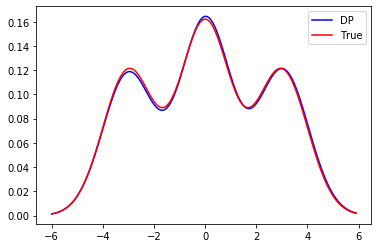

In [0]:
X = np.arange(-6, 6, 0.1)
Y = dpgmm.pdf(X)
plt.plot(X, Y, 'b')
plt.plot(X, gmm.pdf(X), 'r')
plt.legend(['DP', 'True'])

which is quite similar to the true distribution. Now let's look at the formula it learned.

In [0]:
print('Dirichlet Process Learned:\t', dpgmm)
print('True Distribution:\t\t', gmm)

Dirichlet Process Learned:	 0.41 * N(0.02, 1.00) + 0.30 * N(3.04, 1.00) + 0.29 * N(-3.01, 1.00)
True Distribution:		 0.40 * N(0.00, 1.00) + 0.30 * N(-3.00, 1.00) + 0.30 * N(3.00, 1.00)


We could see the parameters ($\mu$s and $\pi$s) are properly learned! The clustering runs very well! 

There's one more question. What if the $\tau$ (or variance) is not fixed to its true value one? My Dirichlet also implement the case where it is not fixed. Let's have a look:

In [0]:
np.random.seed(1)
dpgmm_freetau = DPGaussianMixture(fix_tau=False, alpha=10)
dpgmm_freetau.loadData(data)
dpgmm_freetau.gibbsSampling(itr=20)

Epoch 0...
0.80 * N(0.04, 41.19) + 0.20 * N(0.06, 42.36) + 0.00 * N(-0.22, 36.15)
Epoch 1...
0.80 * N(0.04, 41.28) + 0.20 * N(0.06, 41.89) + 0.00 * N(-0.08, 32.57)
Epoch 2...
0.80 * N(0.04, 41.35) + 0.20 * N(0.02, 41.54) + 0.00 * N(0.26, 37.14) + 0.00 * N(-2.06, 315.43)
Epoch 3...
0.80 * N(0.05, 41.39) + 0.20 * N(0.00, 41.30) + 0.00 * N(0.47, 42.06) + 0.00 * N(-2.06, 315.43)
Epoch 4...
0.80 * N(0.05, 41.34) + 0.20 * N(0.00, 41.46) + 0.00 * N(0.49, 49.83) + 0.00 * N(-2.06, 315.43) + 0.00 * N(0.88, 123.30)
Epoch 5...
0.80 * N(0.05, 41.26) + 0.20 * N(0.01, 41.80) + 0.00 * N(0.36, 49.83) + 0.00 * N(-2.06, 315.43) + 0.00 * N(0.88, 123.30)
Epoch 6...
0.80 * N(0.04, 41.19) + 0.20 * N(0.02, 42.11) + 0.00 * N(0.25, 43.70) + 0.00 * N(-2.06, 315.43) + 0.00 * N(0.88, 123.30)
Epoch 7...
0.80 * N(0.05, 41.22) + 0.20 * N(0.02, 41.99) + 0.00 * N(0.11, 43.46) + 0.00 * N(0.69, 33.24) + 0.00 * N(-2.06, 315.43)
Epoch 8...
0.80 * N(0.05, 41.20) + 0.20 * N(0.01, 42.06) + 0.00 * N(0.09, 46.20) + 0.00 * N(0.6

Sadly, it failed to learn a reasonable results even with a large $\alpha$. It quickly find a component with a very large variance and stays there forever. Let's look at its density function:

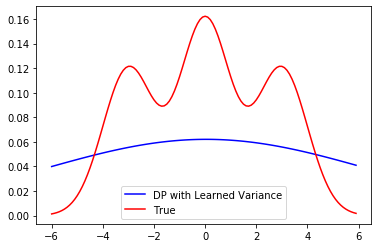

In [0]:
X = np.arange(-6, 6, 0.1)
plt.plot(X, dpgmm_freetau.pdf(X), 'b')
plt.plot(X, gmm.pdf(X), 'r')
plt.legend(['DP with Learned Variance', 'True'])

Quite bad. It tries to use one component to cover all the datapoints. Since we are not given unlimited time, the result after 20 epochs of Gibbs is far from converge because the DP mixture model has too many free degrees. However, when we try to use DP in our project, we definitely do not want such a model. We may just fix the variance to some value (like 1) and learn. Although it will not give us the exact the same components as the data generated, it will give us an (overfitted) estimation. It's hard to learn variance with unknown clusters anyway.

### Conclusion
In this homework, I write a simple Dirichlet Process Mixture Model with Gaussian Components. It managed to learn a reasonable results from a dataset generated by Gaussian Mixture Model when the variance is fixed and failed to do so when variance is not fixed. Both results are expected. There are some questions this homework did not answer, such as what will happen if the dataset is not generated from a Gaussian Mixture Model? What is the best choice for the base distribution (other than Gaussian)? These questions could further explored in the future.